In [5]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.17.2%2Bcu118-cp311-cp311-win_amd64.whl (4.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.2.2%2Bcu118-cp311-cp311-win_amd64.whl (4.0 MB)



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: C:\Users\sahil\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import glob
import shutil
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import PIL
from ultralytics import YOLO

In [2]:
base_dir = os.path.join('D:\\majorProject\\Sahil')

train_dir = os.path.join(base_dir, 'train')
train_img_dir = os.path.join(train_dir, 'images')
train_label_dir = os.path.join(train_dir, 'labels')

test_dir = os.path.join(base_dir, 'test')
test_img_dir = os.path.join(test_dir, 'images')
test_label_dir = os.path.join(test_dir, 'labels')

In [3]:

def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)
        

In [4]:

create_dir(base_dir)

create_dir(train_dir)
create_dir(train_img_dir)
create_dir(train_label_dir)

create_dir(test_dir)
create_dir(test_img_dir)
create_dir(test_label_dir)

In [5]:
dataset_path = 'D:\\majorProject\\Sahil\\dataset'

In [6]:
fruit_count=[]
fruit_name=[]
for i in os.listdir(dataset_path+'/train'):
    fruit_name.append(i)
    fruit_count.append(len(os.listdir(os.path.join(dataset_path+'/train', i))))

In [7]:
fruit_df = pd.DataFrame({'fruit_name':fruit_name, 'fruit_count':fruit_count})

In [8]:
def get_image_range(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 0], dtype = "uint8")
    upper = np.array([255, 50, 255], dtype = "uint8")
    img = cv2.inRange(img, lower, upper)
    img = cv2.blur(img, (2, 2))
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    img = cv2.bitwise_not(thresh)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=lambda x: cv2.contourArea(x))
    
    #get bounding box posotion
    xmin, ymin, xmax, ymax = cv2.boundingRect(contours)
    
    #get the original width,height of the image
    dimensions = img.shape
    h = img.shape[0]
    w = img.shape[1]
    
    #to calculate the bndBox info of this image for yolo
    xp = (xmin + (xmax-xmin)/2) * 1.0 / w
    yp = (ymin + (ymax-ymin)/2) * 1.0 / h
    wp = (xmax-xmin) * 1.0 / w
    hp = (ymax-ymin) * 1.0 / h
    return xp, yp, wp, hp

In [9]:
for dirname, _, filenames in os.walk(dataset_path):
    split_dirname = dirname[1:].split('\\')
    # print(split_dirname)
    if len(split_dirname) >= 2:
        # print(len(split_dirname))
        if split_dirname[-2] == 'train':
            for img_path in glob.glob(dirname+'/*.png'):
                shutil.copy(img_path, os.path.join(train_img_dir, img_path.split('\\')[-1]))
                label=0
                if img_path.split('\\')[-2] == 'freshapples':
                  label=0
                elif img_path.split('\\')[-2] == 'freshbanana':
                  label=1
                elif img_path.split('\\')[-2] == 'freshoranges':
                  label=2
                elif img_path.split('\\')[-2] == 'rottenapples':
                  label=3
                elif img_path.split('\\')[-2] == 'rottenbanana':
                  label=4
                elif img_path.split('\\')[-2] == 'rottenoranges':
                  label=5
                x_center, y_center, box_width, box_height = get_image_range(img_path)
                text = str(label)+' '+str(x_center)+' '+str(y_center)+' '+str(box_width)+' '+str(box_height)
                with open (os.path.join(train_label_dir, img_path.split('\\')[-1][:-4]+'.txt'),'w') as file:
                 file.write(text)
        elif split_dirname[-2] == 'test':
            for img_path in glob.glob(dirname+'/*.png'):
                shutil.copy(img_path, os.path.join(test_img_dir, img_path.split('\\')[-1]))
                label=0
                if img_path.split('\\')[-2] == 'freshapples':
                 label=0
                elif img_path.split('\\')[-2] == 'freshbanana':
                 label=1
                elif img_path.split('\\')[-2] == 'freshoranges':
                  label=2
                elif img_path.split('\\')[-2] == 'rottenapples':
                 label=3
                elif img_path.split('\\')[-2] == 'rottenbanana':
                 label=4
                elif img_path.split('\\')[-2] == 'rottenoranges':
                 label=5
                x_center, y_center, box_width, box_height = get_image_range(img_path)
                text = str(label)+' '+str(x_center)+' '+str(y_center)+' '+str(box_width)+' '+str(box_height)
                with open (os.path.join(test_label_dir, img_path.split('\\')[-1][:-4]+'.txt'),'w') as file:
                    file.write(text)
        

In [10]:
for path in os.listdir(train_img_dir):
    if 'translation' in path:
        os.remove(os.path.join(train_img_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(train_img_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(train_img_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(train_img_dir, path))

In [11]:
for path in os.listdir(train_label_dir):
    if 'translation' in path:
        os.remove(os.path.join(train_label_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(train_label_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(train_label_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(train_label_dir, path))

In [12]:
for path in os.listdir(test_img_dir):
    if 'translation' in path:
        os.remove(os.path.join(test_img_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(test_img_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(test_img_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(test_img_dir, path))

In [13]:
for path in os.listdir(test_label_dir):
    if 'translation' in path:
        os.remove(os.path.join(test_label_dir, path))
    elif 'rotated' in path:
        os.remove(os.path.join(test_label_dir, path))
    elif 'vertical_flip' in path:
        os.remove(os.path.join(test_label_dir, path))
    elif 'saltandpepper' in path:
        os.remove(os.path.join(test_label_dir, path))

In [14]:
yaml_file = """names: 
- fresh_apples 
- fresh_banana
- fresh_oranges
- rotten_apples
- rotten_banana
- rotten_oranges
nc: 6
train: D:\\majorProject\\Sahil\\train\\images
val: D:\\majorProject\\Sahil\\test\\images
"""

with open('D:\\majorProject\\Sahil\\data.yaml', 'w') as f:
    f.write(yaml_file)

In [2]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output
! yolo checks



Ultralytics YOLOv8.1.45 🚀 Python-3.11.9 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)
Setup complete ✅ (16 CPUs, 15.7 GB RAM, 94.2/97.8 GB disk)

OS                  Windows-10-10.0.22631-SP0
Environment         Windows
Python              3.11.9
Install             pip
RAM                 15.71 GB
CPU                 12th Gen Intel Core(TM) i5-1240P
CUDA                11.8

matplotlib          ✅ 3.7.2>=3.3.0
opencv-python       ✅ 4.8.0.74>=4.6.0
pillow              ✅ 10.0.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.1>=1.4.1
torch               ✅ 2.2.2+cu118>=1.8.0
torchvision         ✅ 0.17.2+cu118>=0.9.0
tqdm                ✅ 4.66.1>=4.64.0
psutil              ✅ 5.9.7
py-cpuinfo          ✅ 9.0.0
thop                ✅ 0.1.1-2209072238>=0.1.1
pandas              ✅ 2.2.2>=1.1.4
seaborn             ✅ 0.12.2>=0.11.0


In [16]:
plan_to_delete_from_train = random.sample([i for i in os.listdir(train_img_dir)], 550)
plan_to_delete_from_test = random.sample([i for i in os.listdir(test_img_dir)], 230)

In [17]:
for i in plan_to_delete_from_train:
    os.remove(os.path.join(train_img_dir, i))
    os.remove(os.path.join(train_label_dir, i[:-4]+'.txt'))

for i in plan_to_delete_from_test:
    os.remove(os.path.join(test_img_dir, i))
    os.remove(os.path.join(test_label_dir, i[:-4]+'.txt'))

In [3]:
import torch

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.is_available())


2.2.2+cu118
11.8
1
True


In [6]:
!yolo task=detect \
mode=train \
model=yolov8s.pt \
data='D:\majorProject\YOLO\data.yaml' \
epochs=8 \
imgsz=420 \
device='cuda'



New https://pypi.org/project/ultralytics/8.2.14 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.45 🚀 Python-3.11.9 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=D:\majorProject\YOLO\data.yaml, epochs=8, time=None, patience=100, batch=16, imgsz=420, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho


  0%|          | 0.00/21.5M [00:00<?, ?B/s]
  3%|▎         | 744k/21.5M [00:00<00:02, 7.60MB/s]
  7%|▋         | 1.45M/21.5M [00:00<00:04, 4.29MB/s]
  9%|▉         | 1.98M/21.5M [00:00<00:04, 4.67MB/s]
 12%|█▏        | 2.48M/21.5M [00:00<00:05, 3.68MB/s]
 13%|█▎        | 2.89M/21.5M [00:00<00:05, 3.69MB/s]
 15%|█▌        | 3.32M/21.5M [00:00<00:04, 3.89MB/s]
 17%|█▋        | 3.72M/21.5M [00:01<00:05, 3.35MB/s]
 20%|█▉        | 4.21M/21.5M [00:01<00:04, 3.77MB/s]
 21%|██▏       | 4.60M/21.5M [00:01<00:04, 3.81MB/s]
 23%|██▎       | 4.99M/21.5M [00:01<00:04, 3.86MB/s]
 25%|██▌       | 5.38M/21.5M [00:01<00:04, 3.86MB/s]
 27%|██▋       | 5.77M/21.5M [00:01<00:04, 3.90MB/s]
 29%|██▊       | 6.16M/21.5M [00:01<00:04, 3.90MB/s]
 30%|███       | 6.55M/21.5M [00:01<00:03, 3.93MB/s]
 32%|███▏      | 6.94M/21.5M [00:01<00:03, 3.95MB/s]
 34%|███▍      | 7.32M/21.5M [00:01<00:03, 3.92MB/s]
 36%|███▌      | 7.71M/21.5M [00:02<00:03, 3.94MB/s]
 38%|███▊      | 8.09M/21.5M [00:02<00:03, 3.96MB/s]
 3

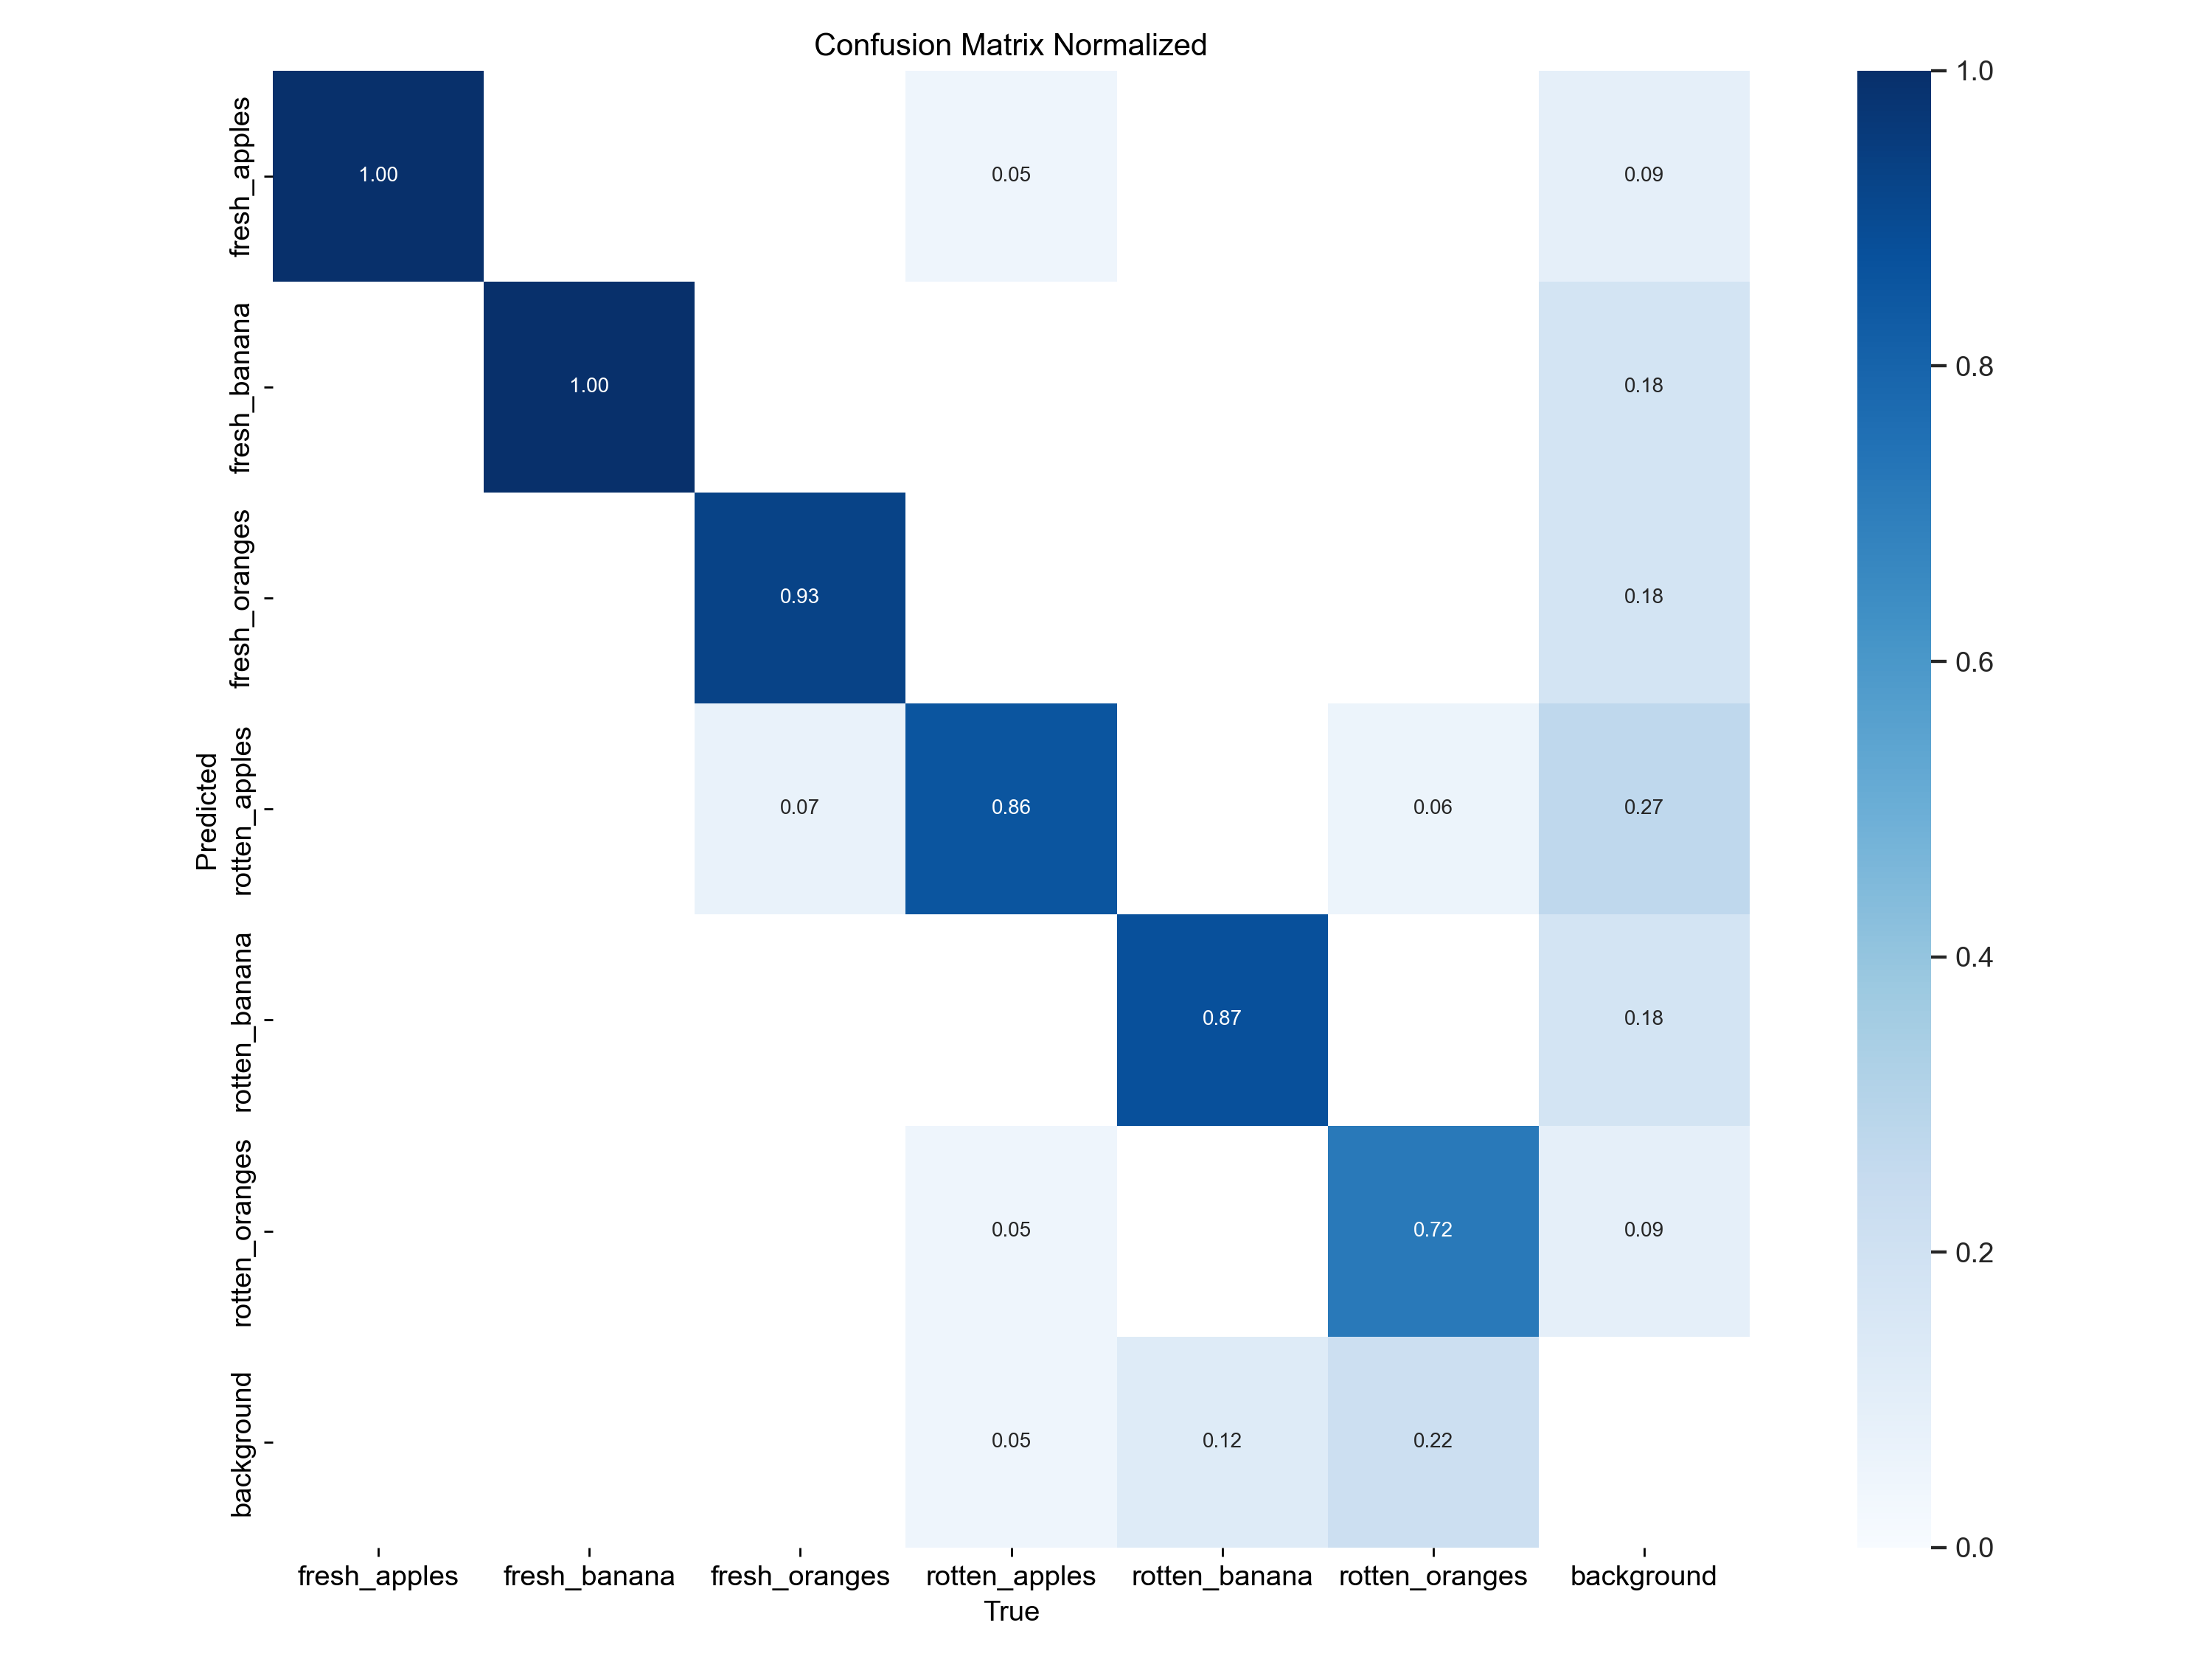

In [8]:
Image('D:\\majorProject\\YOLO\\runs\\detect\\train\\confusion_matrix_normalized.png')

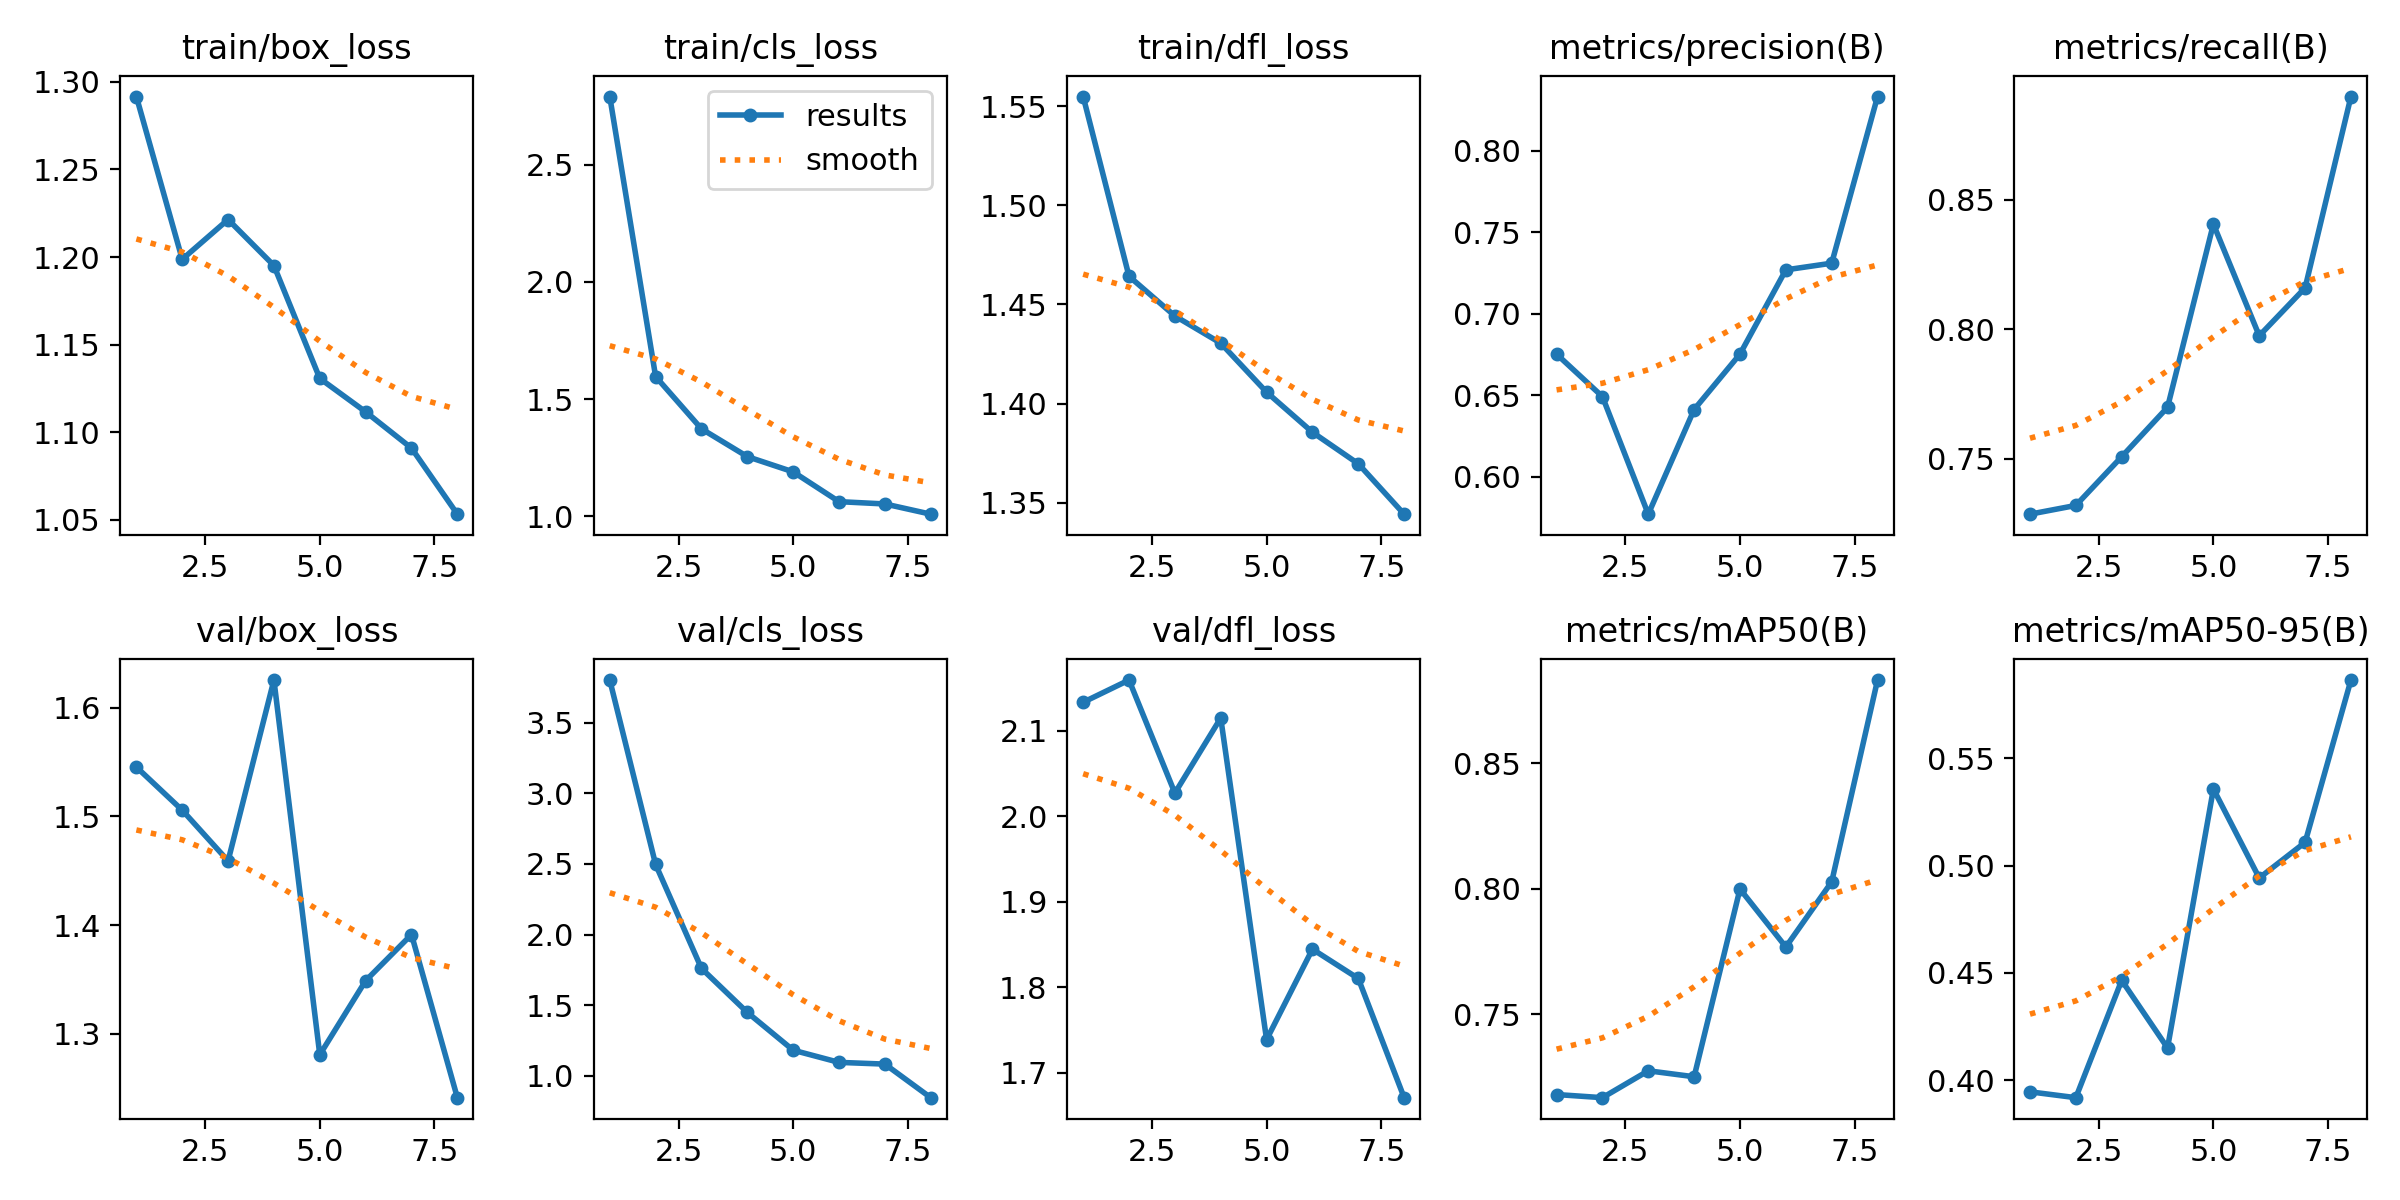

In [9]:
Image('D:\\majorProject\\YOLO\\runs\\detect\\train\\results.png')

In [10]:
! yolo task=detect \
mode=val \
model='D:\\majorProject\\YOLO\\runs\\detect\\train\\weights\\best.pt' \
data='D:\majorProject\YOLO\data.yaml'

Ultralytics YOLOv8.1.45 🚀 Python-3.11.9 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs
val: WARNING ⚠️ D:\majorProject\YOLO\test\images\Screen Shot 2018-06-12 at 11.18.34 PM.png: ignoring corrupt image/label: negative label values [     -0.125]
val: WARNING ⚠️ D:\majorProject\YOLO\test\images\Screen Shot 2018-06-12 at 9.03.34 PM.png: ignoring corrupt image/label: negative label values [   -0.24016]
val: WARNING ⚠️ D:\majorProject\YOLO\test\images\Screen Shot 2018-06-12 at 9.28.04 PM.png: ignoring corrupt image/label: negative label values [  -0.082888]
                   all         96         96      0.836      0.889      0.883      0.586
          fresh_apples         96         15      0.858          1      0.995      0.681
          fresh_banana         96         12      0.837          1      0.963      0.648
         fresh_oranges         96         14      0.901          1      0.986   


val: Scanning D:\majorProject\YOLO\test\labels.cache... 99 images, 0 backgrounds, 3 corrupt: 100%|██████████| 99/99 [00:00<?, ?it/s]
val: Scanning D:\majorProject\YOLO\test\labels.cache... 99 images, 0 backgrounds, 3 corrupt: 100%|██████████| 99/99 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 1/6 [00:05<00:29,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 2/6 [00:06<00:10,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:06<00:04,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 4/6 [00:06<00:02,  1.05s/it]
                 Class     Images  Instances      Box(P     